# Motivation : 
I read an interesting article about anomaly detection: https://iwringer.wordpress.com/2015/11/17/anomaly-detection-concepts-and-techniques/.  
I wanted to try a few of these techniques to better understand them. I searched an interesting dataset on Kaggle about anomaly detection with simple exemples. I choose one exemple of NAB datasets (thanks for this datasets) and I implemented a few of these algorithms. The goal of this Notebook is just to implement these techniques and understand there main caracteristics. Sometimes, they are not adapted to this datasets. I add some visualizations to understand what the algorithm detect. Hope it can help some people.
Notebook available (with Markov Chain) here: https://github.com/Vicam/Unsupervised_Anomaly_Detection

# Algorithm implemented :
- Cluster based anomaly detection (K-mean)
- Repartition of data into categories then Gaussian/Elliptic Enveloppe on each categories separately
- Isolation Forest
- One class SVM

In [1]:
# libraries
#%matplotlib notebook

import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [2]:
# 가장 가까운 centroid와 각 point사이의 distance를 담은 Series를 반환하는 함수
def getDistanceByPoint(data, model):
    distance = pd.Series()
    cluster_cnt = model.labels_.max()
    for i in range(0,len(data)):
        dists = []
        Xa = np.array(data.loc[i])
        for j in range(0,cluster_cnt):
            Xb = model.cluster_centers_[j]
            dists.append(np.linalg.norm(Xa-Xb))

        distance.at[i] = min(dists)
    return distance

# 1 Data
## 1.1 Extract data
The dataset is from https://www.kaggle.com/boltzmannbrain/nab 
In realKnownCause/ambient_temperature_system_failure.csv

- machine_temperature_system_failure.csv
    - 산업용 기계의 내부 구성 요소에 대한 온도 센서 데이터
    - 시스템 종료, 감지하기 어렵거나, 치명적 기계 고장 등에 의해 이상 현상이 발생

In [3]:
# ambient_temperature_system_failure dataset 
df = pd.read_csv("./input/realKnownCause/realKnownCause/machine_temperature_system_failure.csv")

In [4]:
len(df)

22695

## 1.2 Understand data

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22695 entries, 0 to 22694
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  22695 non-null  object 
 1   value      22695 non-null  float64
dtypes: float64(1), object(1)
memory usage: 354.7+ KB
None


In [6]:
# timestamp의 format 확인 및 주기 확인
print(df['timestamp'].head(10))

0    2013-12-02 21:15:00
1    2013-12-02 21:20:00
2    2013-12-02 21:25:00
3    2013-12-02 21:30:00
4    2013-12-02 21:35:00
5    2013-12-02 21:40:00
6    2013-12-02 21:45:00
7    2013-12-02 21:50:00
8    2013-12-02 21:55:00
9    2013-12-02 22:00:00
Name: timestamp, dtype: object


In [7]:
# temperature의 mean 값 확인
print(df['value'].mean())

85.92649821068021


<AxesSubplot:xlabel='timestamp'>

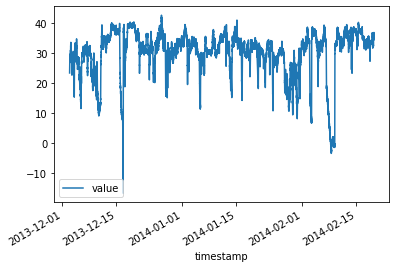

In [8]:
# plotting 하기위해 timestamp column의 type 변경
df['timestamp'] = pd.to_datetime(df['timestamp'])

# temperature의 단위를 °F 화씨에서 °C 도씨로 변경
df['value'] = (df['value'] - 32) * 5/9

# plot the data
df.plot(x='timestamp', y='value')

## 1.3 Feature engineering
Extracting some useful features

In [9]:
# hours column 추가 (0~23)
df['hours'] = df['timestamp'].dt.hour

# 밤/낮을 구분하기 위한 daylight column 추가
# 07:00~22:00 : 0 // 22:00~07:00 : 1
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

In [10]:
# 한 주를 요일(월~일)로 나타내기 위한 DayOfTheWeek colume 추가
# Monday = 0 ~ Sunday = 6
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek

# 주말(토, 일)을 나타내는 WeekDay colume 추가
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)

# dataset의 이상 population 추정(outlier) 비율 // 일부 알고리즘에서 사용
outliers_fraction = 0.01

In [11]:
# 쉽게 plot하기 위해 time을 int로 변경
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

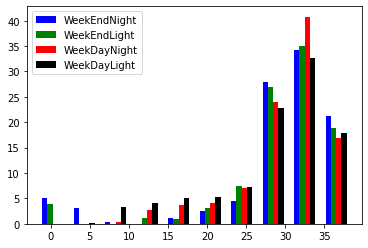

In [12]:
# 다음 4개의 카테고리 생성 (새로운 Feature 생성)
# WeekEndNight : 주말 저녁
# WeookEndLight : 주말 낮
# WeekDayNight : 평일 저녁
# WeekDayLight : 평일 낮

df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value'] # 주말 저녁의 Temperature
b = df.loc[df['categories'] == 1, 'value'] # 주말 낮의 Temperature
c = df.loc[df['categories'] == 2, 'value'] # 평일 저녁의 Temperature
d = df.loc[df['categories'] == 3, 'value'] # 평일 낮의 Temperature

fig, ax = plt.subplots()

# bins : 도수분포 구간, 도수분포 구간은 주말 저녁 Temperature 데이터 분포구간으로 통일
# O_heights : 도수분포표의 각 구간에 있는 data 수
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

# bar chart의 너비를 조정
width = (a_bins[1] - a_bins[0])/6

# 각 카테고리에 따른 데이터 분포를 백분률로 나타내기 위해 (O_heights*100/O.count) 연산법을 사용 
ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()

In [13]:
np.sum(d_heights*100/d.count())

98.4735632183908

We can see that the temperature is more stable during daylight of business day.
# 2 Models
## 2.1 Cluster only
#### Use for collective anomalies (unordered). 

We group together the usual combination of features. The points that are far from the cluster are points with usual combination of features.We consider those points as anomalies.

In [14]:
# Useful한 feature 추출 및 스케일링(StandardScaler)
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

# reduce to 2 importants features
# 2개의 important feature까지 차원을 줄여나감
pca = PCA(n_components=2)
data = pca.fit_transform(data)

# standardize these 2 new features
# 2개의 feature에 대해 스케일링 진행
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

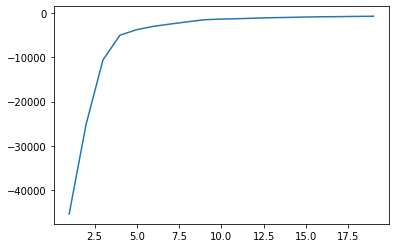

In [15]:
# centroids의 다른 숫자 계산 보기위해 loss plot을
# loss plot을 보기위해 centroids의 다른 숫자들과 함께 계산..?
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [16]:
# 임의로 15개의 centroids를 선택 및 central dataframe에 선택된 데이터들을 더함
df['cluster'] = kmeans[14].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

4     1848
2     1848
3     1628
12    1586
6     1568
13    1553
9     1543
8     1539
10    1520
11    1498
0     1422
7     1409
14    1352
1     1233
5     1148
Name: cluster, dtype: int64

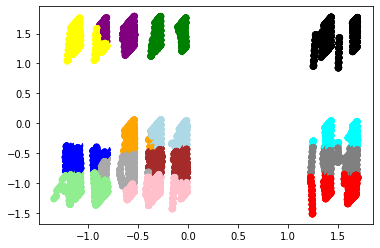

In [17]:
# 2개의 main feature들과 함께 다른 cluster들을 plot
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [ ]:
# 각 point와 가장 가까운 centroid 사이의 distance 계산 
# 가장 큰 distanace를 anomaly로써 간주
distance = getDistanceByPoint(data, kmeans[14])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()

# 메인 Dataframe에 PCA 및 Clustering을 사용한 anomaly detection 결과를 저장
# anomaLy21은 0은 normal로 1은 anomaly로 클러스터링을 진행한 결과
df['anomaly21'] = (distance >= threshold).astype(int)

d:\programdata\junseok\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# cluster 및 cluster 중 anomaly 시각화
# 파란색 = normal / 빨간색 = red
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly21"].apply(lambda x: colors[x]))
plt.show()

In [ ]:
# 시간 도메인에서의 anomaly 시각화
fig, ax = plt.subplots()

a = df.loc[df['anomaly21'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

In [ ]:
# 온도 분포 및 anomaly 온도 분포 시각화
a = df.loc[df['anomaly21'] == 0, 'value']
b = df.loc[df['anomaly21'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

Cluster method detects the low temperature around the end of record as unusually low. It doesn't detect the highest temperature pic.
## 2.2 Categories + Gaussian
#### Use for contextual data and collective anomalies (unordered).  
We will separate data by (what we think of) important categories. Or we can separate data based on different cluster (method 2.3). Then we find outliers (gaussian repartition, unimodal) by categories independently.   

In [ ]:
# 다음 4개의 카테고리 생성 (새로운 Feature 생성)
# WeekEndNight : 주말 저녁
# WeookEndLight : 주말 낮
# WeekDayNight : 평일 저녁
# WeekDayLight : 평일 낮
df_class0 = df.loc[df['categories'] == 0, 'value']
df_class1 = df.loc[df['categories'] == 1, 'value']
df_class2 = df.loc[df['categories'] == 2, 'value']
df_class3 = df.loc[df['categories'] == 3, 'value']

In [ ]:
# 각 카테고리에 따른 온도 분포 plot
fig, axs = plt.subplots(2,2)
df_class0.hist(ax=axs[0,0],bins=32)
df_class1.hist(ax=axs[0,1],bins=32)
df_class2.hist(ax=axs[1,0],bins=32)
df_class3.hist(ax=axs[1,1],bins=32)

In [ ]:
# 각 카테고리에 대해 Gaussian distribution 적용
# Normal : 1
# Anomaly : -1 
envelope =  EllipticEnvelope(contamination = outliers_fraction) 

# WeekEndNight(주말 저녁)에 대한 gaussian distribution 생성
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

# WeokEndLight(주말 낮)에 대한 gaussian distribution 생성
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

# WeekDayNight(평일 저녁)에 대한 gaussian distribution 생성
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class2.values.reshape(-1,1)
envelope.fit(X_train)
df_class2 = pd.DataFrame(df_class2)
df_class2['deviation'] = envelope.decision_function(X_train)
df_class2['anomaly'] = envelope.predict(X_train)

# WeekDayLight(평일 낮)에 대한 gaussian distribution 생성
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class3.values.reshape(-1,1)
envelope.fit(X_train)
df_class3 = pd.DataFrame(df_class3)
df_class3['deviation'] = envelope.decision_function(X_train)
df_class3['anomaly'] = envelope.predict(X_train)

In [ ]:
# 각 카테고리들과 anomaly가 포함된 temperature 분포 plot
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'value']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'value']

a1 = df_class1.loc[df_class1['anomaly'] == 1, 'value']
b1 = df_class1.loc[df_class1['anomaly'] == -1, 'value']

a2 = df_class2.loc[df_class2['anomaly'] == 1, 'value']
b2 = df_class2.loc[df_class2['anomaly'] == -1, 'value']

a3 = df_class3.loc[df_class3['anomaly'] == 1, 'value']
b3 = df_class3.loc[df_class3['anomaly'] == -1, 'value']

fig, axs = plt.subplots(2,2)
axs[0,0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,1].hist([a1,b1], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,0].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,1].hist([a3,b3], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,0].set_title("WeekEndNight")
axs[0,1].set_title("WeekEndLight")
axs[1,0].set_title("WeekDayNight")
axs[1,1].set_title("WeekDayLight")
plt.legend()
plt.show()

In [ ]:
# 메인 Dataframe에 Categories + Gaussian을 사용한 anomaly detection 결과를 저장
df_class = pd.concat([df_class0, df_class1, df_class2, df_class3])
df['anomaly22'] = df_class['anomaly']
df['anomaly22'] = np.array(df['anomaly22'] == -1).astype(int) 

In [ ]:
# 시간 도메인에서의 anomaly 시각화
fig, ax = plt.subplots()

a = df.loc[df['anomaly22'] == 1, ('time_epoch', 'value')] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

In [ ]:
# 온도 분포 및 anomaly 온도 분포 시각화
# 메인 Dataframe인 df에 normal은 0으로 anomaly는 1로 저장
a = df.loc[df['anomaly22'] == 0, 'value']
b = df.loc[df['anomaly22'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

Detect unusual sequence but not extreme value. More difficult to evaluate the relevance on this example. The sequence size (5) should be match with some interesting cycle.
## 2.5 Isolation Forest
#### Use for collective anomalies (unordered).
Simple, works well with different data repartition and efficient with high dimention data.

In [ ]:
# Useful한 feature 추출 및 스케일링(StandardScaler)
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

# isolation forest 학습
# Dataset 중 outliers_fraction(0.01)에 해당하는 데이터를 anomaly로 판단
# Normal : 1
# Anomaly : -1
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)

# 메인 Dataframe에 Isolation Forest를 사용한 anomaly detection 결과를 저장
df['anomaly25'] = pd.Series(model.predict(data))

# normal은 0으로, anomaly는 1로 mapping
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )
print(df['anomaly25'].value_counts())

In [ ]:
# 시간 도메인에서의 anomaly 시각화
fig, ax = plt.subplots()

a = df.loc[df['anomaly25'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

In [ ]:
# 온도 분포 및 anomaly 온도 분포 시각화
a = df.loc[df['anomaly25'] == 0, 'value']
b = df.loc[df['anomaly25'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
plt.legend()
plt.show()

## 2.6 One class SVM
#### Use for collective anomalies (unordered).
Good for novelty detection (no anomalies in the train set). This algorithm performs well for multimodal data.

In [ ]:
# Useful한 feature 추출 및 스케일링(StandardScaler)
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)

# One class SVM 학습
# Dataset 중 outliers_fraction(0.01)에 해당하는 데이터를 anomaly로 판단
# nu : SVM에서 Hypert plane 밖에 있는 데이터의 최대 비율, nu가 0.1일 경우, 최대 10%정도를 전체 데이터 중 anomaly로 가정
# Normal : 0
# Anomaly : 1
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)

# 메인 Dataframe에 One class SVM을 사용한 anomaly detection 결과를 저장
df['anomaly26'] = pd.Series(model.predict(data))
df['anomaly26'] = df['anomaly26'].map( {1: 0, -1: 1} )
print(df['anomaly26'].value_counts())

In [ ]:
# 시간 도메인에서의 anomaly 시각화
fig, ax = plt.subplots()

a = df.loc[df['anomaly26'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

In [ ]:
# 온도 분포 및 anomaly 온도 분포 시각화
a = df.loc[df['anomaly26'] == 0, 'value']
b = df.loc[df['anomaly26'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()